In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from datetime import timedelta

plt.style.use('fivethirtyeight') # Use plt.style.available to see more styles
sns.set()
sns.set_context("talk")
%matplotlib inline

In [2]:
# load both singal.csv and tresspasser.csv files 

df_tresspasser = pd.read_csv("data/trespasser/221002/Midland.csv", index_col=0)
df_signal = pd.read_csv("data/signal.csv", index_col=0)

#because we can not see the value clearly, so we only look at one day
#df_tresspasser = df_tresspasser[df_tresspasser['start_time'].str.match('^10/2/2022.*M$')== True]
#df_signal = df_signal[df_signal['start_time'].str.match('^10/2/2022.*M$')== True]


#display(df_tresspasser.head(2))
#display(df_signal.head())

## Below is processing with signal.csv data(finding out the signal during time)

In [3]:

# Change the string to datetime
df_signal['start_time'] = pd.to_datetime(df_signal['start_time'])
df_signal['end_time'] = pd.to_datetime(df_signal['end_time'])

# Calculate "duration"
df_signal['duration'] = (df_signal['end_time']-df_signal['start_time'])
df_signal['duration_time'] = (df_signal['end_time']-df_signal['start_time']).dt.total_seconds()

'''
# Remove Outliers in Data, keep between 0.5% and 99.5%
q_low = df_signal["duration_time"].quantile(0.005)
q_hi  = df_signal["duration_time"].quantile(0.995)
df_signal_filter = df_signal[(df_signal["duration_time"] < q_hi) & (df_signal["duration_time"] > q_low)]
'''
#temp
df_signal_filter = df_signal


#display(df_signal.head(3))
#plot1 = df_signal_filter.plot(x='start_time', y='duration_time', style=".")

## Below is processing with "trespasser" data

In [4]:
NofT = df_tresspasser['validation'].value_counts()[True]
NofF = df_tresspasser['validation'].value_counts()[False]
# Change the string to datetime
df_tresspasser['start_time'] = pd.to_datetime(df_tresspasser['start_time'])
df_tresspasser['end_time'] = pd.to_datetime(df_tresspasser['end_time'])

# Create a new dataframe and Record the Number of "True" and "False" by specific "time intervel"
index = 0
update_minus =5 # unit minus
updated_time = df_tresspasser['start_time'][0]+ timedelta(minutes=update_minus)
nTrue = 0
nFalse = 0

df_tress = pd.DataFrame({
    'timestape': [],
    'numberOfTrue': [],
    'numberOfFalse': []
})


while index < len(df_tresspasser.index):
    if df_tresspasser['start_time'][index] <= updated_time:
        if df_tresspasser['validation'][index] == True:
            nTrue = nTrue+1
        else:
            nFalse = nFalse+1
        index = index+1
        
    else:
        temp = {'timestape': updated_time, 'numberOfTrue': nTrue, 'numberOfFalse': nFalse}
        df_tress = df_tress.append(temp, ignore_index = True)
        updated_time = updated_time + timedelta(minutes=update_minus)
        if df_tresspasser['validation'][index] == True:
            nTrue = 0
            nFalse = 0
        else:
            nFalse = 0
            nTrue = 0

        
    

#display(df_tress.sort_values(by=['numberOfFalse'], ascending=False).head())
#df_tress.set_index('timestape').plot(style=".")

In [7]:
# fill out False not equal to 0 and create a new dataframe "df_tress_sub"


index = 0
df_tress_sub = pd.DataFrame({
    'timestape': [],
    'numberOfFalse': []
})

while index < len(df_tress.index):
    if df_tress['numberOfFalse'][index] != 0:
        temp = {'timestape': df_tress['timestape'][index], 'numberOfFalse': df_tress['numberOfFalse'][index]}
        df_tress_sub = df_tress_sub.append(temp, ignore_index = True)
    index = index + 1
    

display(df_tress_sub.head())

,timestape,numberOfFalse
0,2022-10-02 10:55:55,1.0
1,2022-10-02 11:55:55,1.0
2,2022-10-02 14:50:55,1.0
3,2022-10-02 18:00:55,1.0
4,2022-10-02 18:05:55,1.0


## 'df_tress_sub' : try to find out if there are overlaping date between *Train Pass* and *False data*

In [13]:
# find out if the "df_tress_signal" match the Train Pass time IF THERE ARE OVERLAP TIME

df_tress_signal = pd.DataFrame({
    'timestape_start': [],
    'timestape_end': [],
    'timestape_train_start': [],
    'timestape_train_end': [],
    'signal_duration_time': [],
    'numberOfFalse': []
    
})


index = 0
count = 0
update_minus =5 # unit minus, number should same as before

while index < len(df_tress_sub.index):
    start_time = df_tress_sub['timestape'][index]- timedelta(minutes=update_minus)
    end_time = df_tress_sub['timestape'][index]

    index2 = 0
    while index2 < len(df_signal_filter.index):
        if (start_time < df_signal_filter['start_time'][index2]) & (end_time >  df_signal_filter['start_time'][index2]):
            count = count +1
            temp = {'timestape_start': start_time, 'timestape_end': end_time, 
                    'timestape_train_start': df_signal_filter['start_time'][index2], 'timestape_train_end': df_signal_filter['end_time'][index2],
                    'signal_duration_time': df_signal_filter['duration_time'][index2],
                    'numberOfFalse': df_tress_sub['numberOfFalse'][index] }
            df_tress_signal = df_tress_signal.append(temp, ignore_index = True)

        index2 = index2 + 1
        
    index = index + 1

display(df_tress_signal)   


    


,timestape_start,timestape_end,timestape_train_start,timestape_train_end,signal_duration_time,numberOfFalse
0,2022-10-02 10:50:55,2022-10-02 10:55:55,2022-10-02 10:51:35,2022-10-02 10:55:31,236.0,1.0
1,2022-10-02 14:45:55,2022-10-02 14:50:55,2022-10-02 14:47:43,2022-10-02 14:50:20,157.0,1.0
2,2022-10-02 17:55:55,2022-10-02 18:00:55,2022-10-02 17:55:57,2022-10-02 17:56:51,54.0,1.0
3,2022-10-02 17:55:55,2022-10-02 18:00:55,2022-10-02 17:59:59,2022-10-02 18:02:57,178.0,1.0
4,2022-10-02 22:50:55,2022-10-02 22:55:55,2022-10-02 22:51:12,2022-10-02 22:53:57,165.0,1.0
5,2022-10-03 05:10:55,2022-10-03 05:15:55,2022-10-03 05:12:46,2022-10-03 05:13:52,66.0,1.0
6,2022-10-03 05:40:55,2022-10-03 05:45:55,2022-10-03 05:41:43,2022-10-03 05:42:39,56.0,1.0
7,2022-10-03 09:00:55,2022-10-03 09:05:55,2022-10-03 09:01:35,2022-10-03 09:04:03,148.0,2.0
8,2022-10-03 12:05:55,2022-10-03 12:10:55,2022-10-03 12:06:54,2022-10-03 12:09:38,164.0,1.0
9,2022-10-03 17:55:55,2022-10-03 18:00:55,2022-10-03 17:57:32,2022-10-03 18:00:50,198.0,7.0


In [14]:
print(f'There are {count} Train Passing event happen between the Timestape')
print(f'So the possiblity is {count/len(df_tress_sub.index)*100}% ')

There are 42 Train Passing event happen between the Timestape
So the possiblity is 85.71428571428571% 


## 'df_signal_contain_tress' : try to find out if *Train Pass time* contain *False data*

In [15]:
# find out if the "df_tress_signal" match the Train Pass time IF THERE ARE OVERLAP TIME
# df_tresspasser
df_signal_contain_tress = pd.DataFrame({
    'timestape_signal_start': [],
    'timestape_signal_end': [],
    'signal_duration_time': [],
    'number_of_tress_during_signal': []
})


index = 0
while index < len(df_signal_filter.index):
    #print(index)
    start_signal_time = df_signal_filter['start_time'][index]
    end_signal_time = df_signal_filter['end_time'][index]

    index2 = 0
    count = 0
    while index2 < len(df_tresspasser.index):
        if(df_tresspasser['validation'][index2] ==  False):
            if (start_signal_time <= df_tresspasser['start_time'][index2]) & (end_signal_time >=  df_tresspasser['end_time'][index2]):
                count = count +1

        index2 = index2 + 1
    
    if (count != 0):
        temp = {'timestape_signal_start': start_signal_time, 'timestape_signal_end': end_signal_time,                 
                'signal_duration_time': df_signal_filter['duration_time'][index],
                'number_of_tress_during_signal': int(count)
                 }
        df_signal_contain_tress = df_signal_contain_tress.append(temp, ignore_index = True)

        
    index = index + 1
    
 
display(df_signal_contain_tress)



    


,timestape_signal_start,timestape_signal_end,signal_duration_time,number_of_tress_during_signal
0,2022-10-03 05:12:46,2022-10-03 05:13:52,66.0,1.0
1,2022-10-03 17:57:32,2022-10-03 18:00:50,198.0,7.0
2,2022-10-03 18:15:33,2022-10-03 18:16:56,83.0,1.0
3,2022-10-03 20:14:35,2022-10-03 20:15:37,62.0,1.0
4,2022-10-03 23:43:59,2022-10-03 23:46:54,175.0,1.0
5,2022-10-04 07:01:02,2022-10-04 07:01:57,55.0,3.0
6,2022-10-04 07:17:30,2022-10-04 07:18:18,48.0,4.0
7,2022-10-04 07:20:36,2022-10-04 07:23:42,186.0,13.0
8,2022-10-04 07:29:01,2022-10-04 07:30:30,89.0,6.0
9,2022-10-04 07:33:49,2022-10-04 07:34:40,51.0,1.0


## Find out the possibility and figure with the data above

The total number of 'False' in this CSV:  85
The number of 'False' occur during the signal(Train Passing event): 60.0
So 70.58823529411765% of 'False' occur during the Signal(Train Passing event)'


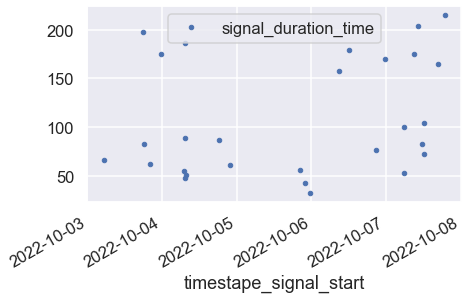

In [18]:
TotalNumberFalse = 0

index = 0
while index < len(df_tresspasser.index):
    if(df_tresspasser['validation'][index] ==  False):
        TotalNumberFalse = TotalNumberFalse + 1
    index = index + 1

NumberFalseDuringSignal = df_signal_contain_tress['number_of_tress_during_signal'].sum()

print("The total number of 'False' in this CSV: ", TotalNumberFalse)
print("The number of 'False' occur during the signal(Train Passing event):", NumberFalseDuringSignal)
print(f"So {NumberFalseDuringSignal/TotalNumberFalse * 100}% of 'False' occur during the Signal(Train Passing event)'")
#display(df_signal_contain_tress)
plot1 = df_signal_contain_tress.plot(x='timestape_signal_start', y='signal_duration_time', style=".")
        

        

## Using the figure to show which Train Passing occur the tresspasser

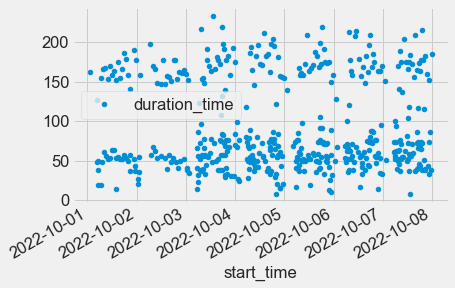

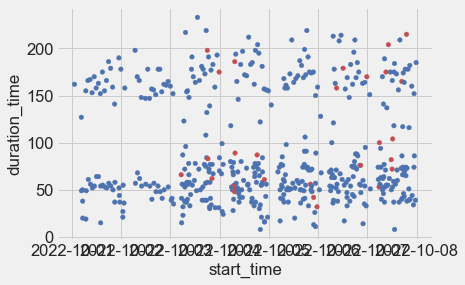

In [73]:
import datetime
 
# Function to convert string to datetime

 
 
# Driver code
# Because the Tresspasser file only till to 2022-10-08
date_time = '2022-10-08'
timedue = pd.to_datetime(date_time)

q_low = df_signal["duration_time"].quantile(0.005)
q_hi  = df_signal["duration_time"].quantile(0.995)
df_signal_filter_temp = df_signal[(df_signal["duration_time"] < q_hi) & (df_signal["duration_time"] > q_low)]

#find out the row number of 
index = 0
while index < len(df_signal_filter_temp.index):
    if df_signal_filter_temp['start_time'][index] > timedue:
        timedueNumber = index
        break
    index = index + 1

# cut the df
df_signal_filter_temp = df_signal_filter_temp.drop(df_signal_filter_temp.index[range(timedueNumber, len(df_signal_filter_temp.index))])

# If the train pass occur the tresspassing, mark as "red"
col1 =[]
index = 0
count = 0
while index < len(df_signal_filter_temp.index):
    index2 = 0
    contain = False
    while index2 < len(df_signal_contain_tress.index):
        if df_signal_contain_tress['timestape_signal_start'][index2] == df_signal_filter_temp['start_time'][index]:
            col1.append('r')  
            contain = True
            count = count +1
        index2 = index2 + 1   
    if contain == False:  
        col1.append('b')      
    index = index + 1
    

ax = df_signal_filter_temp.plot(x='start_time', y='duration_time', style=".")
ax2 = df_signal_filter_temp.plot.scatter(x='start_time', y='duration_time', c = col1)




###  Graph Anootation
The first graph above is a graph of Signal (Train Passing event) occurring at various points in time.

In the second diagram below, the blue points are when Signal(Train Passing event) occurs and no Tresspassing occurs. And the red point is when Signal(Train Passing event) occurs, and there is Tresspassing occurring.